<font color='blue' size='5px'/> Implement in Project<font/>

# 1 Packages

In [3]:
!pip install keras-cv-attention-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.8/748.8 kB 12.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds 
#from kaggle_datasets import KaggleDatasets

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
from keras.layers import Input,Dense, Flatten,Dropout,Conv2D,GlobalAveragePooling2D,MaxPool2D
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, ZeroPadding2D
from tensorflow.keras.applications import EfficientNetB5
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from keras_cv_attention_models import convnext
from keras_cv_attention_models import mobilenetv3

In [7]:
from multiprocessing import cpu_count
from tqdm.notebook import tqdm

In [8]:
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
import os
import PIL
import PIL.Image
import pickle 
import math
import cv2
import datetime
import random
import shutil
import time
import gc
import sys

print(f'Tensorflow Version: {tf.__version__}')
print(f'Python Version: {sys.version}')

Tensorflow Version: 2.12.0
Python Version: 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]


In [10]:
from keras.models import *
from keras import models
from keras.models import Model
from keras import layers
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Add
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import DepthwiseConv2D
from keras.layers import ZeroPadding2D
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import softmax

In [11]:
from keras.utils.layer_utils import get_source_inputs
from keras.utils.data_utils import get_file

# 2 Explore Data

In [17]:
num_classes=10

## 2.1 Train

$$ Train$$

In [12]:
img=cv2.imread('/kaggle/input/blind-aid-color-recognition/Color Recognition/Test/black/black22.png')

In [13]:
img.shape

(600, 900, 3)

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/blind-aid-color-recognition/Color Recognition/Train',
    seed=0,
    image_size=(256, 256),
    batch_size=2,
    labels='inferred',  # Infer labels from subdirectory names
    label_mode='int'  # Use integer labels
)

# Manually encode the target labels into one-hot vectors
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))


Found 150 files belonging to 10 classes.


## 2.1 Validation

$$ Val$$

In [19]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/blind-aid-color-recognition/Color Recognition/Valid',
    seed=0,
    image_size=(256, 256),
    batch_size=2,
    labels='inferred',  # Infer labels from subdirectory names
    label_mode='int'  # Use integer labels
)

# Manually encode the target labels into one-hot vectors
valid_ds = valid_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))


Found 50 files belonging to 10 classes.


## 2.3 Testing

$$ Test$$

In [20]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/blind-aid-color-recognition/Color Recognition/Test',
    seed=0,
    image_size=(256, 256),
    batch_size=2,
    labels='inferred',  # Infer labels from subdirectory names
    label_mode='int'  # Use integer labels
)

# Manually encode the target labels into one-hot vectors
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))


Found 50 files belonging to 10 classes.


In [21]:
AutoTune=tf.data.AUTOTUNE
train_ds=train_ds.prefetch(buffer_size=AutoTune)
val_ds=valid_ds.prefetch(buffer_size=AutoTune)
test_ds= test_ds.prefetch(buffer_size=AutoTune)

# 3 Freature Engineering 

## 3.1 Preprocessing Data

### 3.1.1 Randomize the Input Image

In [22]:
# Seed all random number generators
def seed_everything(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

### 3.1.2 Normalize the Image to be  similar to Image trained on

In [23]:
def normalize(image):
# Repeat channels to create 3 channel images required by pretrained ConvNextV2 models
# image = tf.repeat(image, repeats=3, axis=3)
    # Repeat channels to create 3 channel images required by pretrained ConvNextV2 models
    # image=tf.repeat(image,repeats=3,axis=3)
    # Cast to float32
    image=tf.cast(image,tf.float32)
    #Normalize with respect to ImageNet Mean
    image=tf.keras.applications.imagenet_utils.preprocess_input(image,mode='torch')
    return image

In [24]:
STRATEGY=tf.distribute.MirroredStrategy()
N_REPLICAS=STRATEGY.num_replicas_in_sync

In [25]:
N_REPLICAS

2

## 3.2 Feature Extraction

## 3.3 Dimensionality Reduction

We will use Pooling in Training

# 4 Preprocessing

We will split data and normalize it at the same time using ImageGenerator. Adding to that we will introduce some variation. The class will be defined based on class_mode from flow_from_directory fn

# 5 Training

## 5.1 Input Parameters

In [26]:
N_EPOCHS=5
VERBOSE=1
N_REPLICAS=2
LR_MAX= 5e-6 * N_REPLICAS
WD_RATIO=1e-5
N_WARMUP_EPOCHS=0
num_classes=10

## 5.2 Weight Decay Function

 <details>
    <summary> Weight Decay</summary>
    
 Tensorflow Learning Rate Scheduler does not update weight decay, need to do it manually in a custom callback
- Weight decay is a regularization technique commonly used during model training to prevent overfitting.
- It is also known as L2 regularization or Ridge regularization. 
- The purpose of weight decay is to add a penalty term to the loss function that discourages the model from assigning excessively large weights to the parameters.
</details>

In [27]:
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

## 5.3 Learning Rate Function

In [28]:
# Learning rate scheduler with logaritmic warmup and cosine decay
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        return lr_max * 0.10 ** (num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [29]:
LR_SCHEDULE = [lrfn(step, num_warmup_steps= N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=.5) for step in range(N_EPOCHS)]
lr_callback=tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step],verbose=0)

## 5.4 EfficientNetB5 & ImageNet Base Model


In [30]:
def get_model():
    # Verify Mixed Policy settings
    # Print('f'compute dtype)
    
    INPUT_SHAPE=(256,256,3)
    
    with STRATEGY.scope():
        # Set seed for deterministic weights intializations
        seed_everything()
        
        # Input, note the names are equal to directory keys in dataset
        image=tf.keras.layers.Input(INPUT_SHAPE, name='image',dtype=tf.uint8)
        
        
        # Nomalize Input
        image_norm=normalize(image)
        
        # CNN Prediciton in range [0,1]
        x = EfficientNetB5(weights='imagenet',include_top=False,input_shape=[256,256,3])(image_norm)
        
            ##'imagenet21k-ft1k',imagenet21k-ftlk'
        
        
        
        # Average Pooling BxhxNxC -> BxC
        x=GlobalAveragePooling2D()(x)
        # Dropout 
        x=Dropout(.5)(x) #

        # Output softmax
        
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        
        
        ## We will use Adam optimizer for fast learning with weight decap
        optimizer=tfa.optimizers.AdamW(learning_rate=LR_MAX,weight_decay=LR_MAX*WD_RATIO,epsilon=1e-6)
        
        # Loss
        loss = tf.keras.losses.CategoricalCrossentropy()
        
        # Metrics
        metrics = [
            tfa.metrics.F1Score(num_classes=num_classes),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.BinaryAccuracy()]
        
        model=Model(inputs=image,outputs=outputs)
        
        model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
        
        return model


In [31]:
LR_SCHEDULE = [lrfn(step, num_warmup_steps= N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=.5) for step in range(N_EPOCHS)]
lr_callback=tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step],verbose=0)
model=get_model()

115263384/115263384 [==============================] - 1s 0us/step


In [32]:
history=model.fit(train_ds,
                  validation_data=valid_ds,
                  epochs=N_EPOCHS,
                  verbose=VERBOSE,
                  callbacks=[lr_callback,
                             WeightDecayCallback()])

learning rate: 1.00e-05, weight decay: 1.00e-10
Epoch 1/5


2023-10-16 14:59:32.491607: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


75/75 [==============================] - 18s 237ms/step - loss: 2.2093 - f1_score: 0.2691 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6961 - binary_accuracy: 0.9000 - val_loss: 2.2914 - val_f1_score: 0.0705 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5584 - val_binary_accuracy: 0.9000 - lr: 9.0451e-06
learning rate: 6.55e-06, weight decay: 6.55e-11
Epoch 3/5
75/75 [==============================] - 19s 247ms/step - loss: 2.1737 - f1_score: 0.2819 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7455 - binary_accuracy: 0.9000 - val_loss: 2.3276 - val_f1_score: 0.0278 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4793 - val_binary_accuracy: 0.9000 - lr: 6.5451e-06
learning rate: 3.45e-06, weight decay: 3.45e-11
Epoch 4/5
75/75 [==============================] - 17s 226ms/step - loss: 2.1216 - f1_score: 0.4165 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7903 - binary_accuracy: 0.9000 - val_loss: 2.3147 - val_f1_score: 0.07

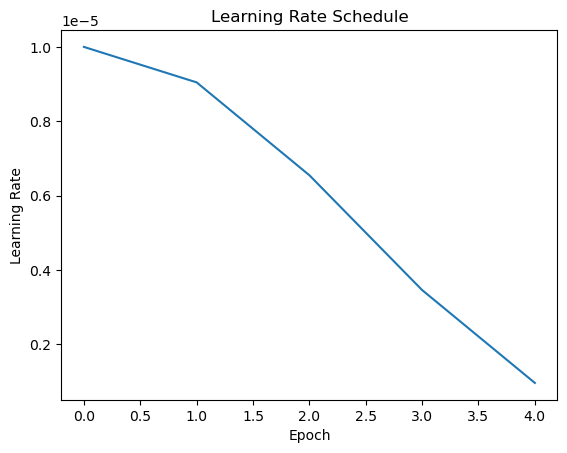

In [33]:
plt.plot(LR_SCHEDULE)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

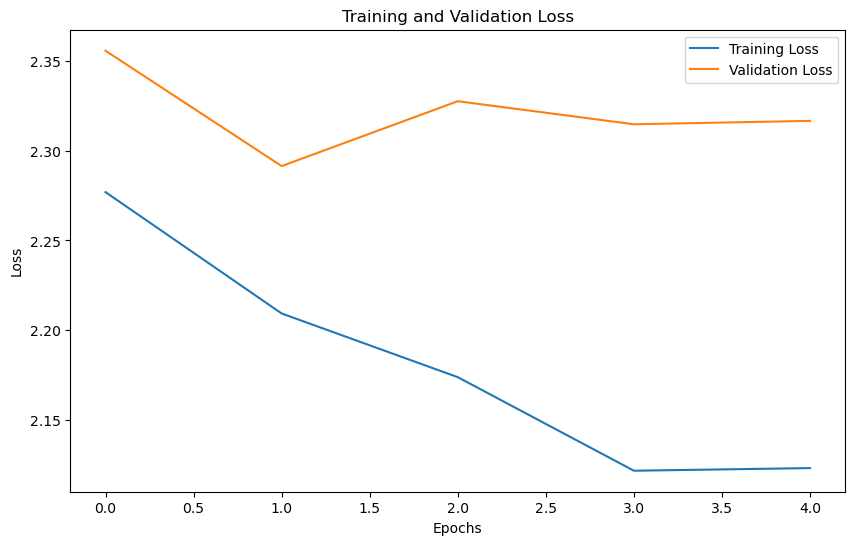

In [34]:
# Get training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5.6 EfficientNetB7 & ImageNet Base Model


In [54]:
def get_model():
    # Verify Mixed Policy settings
    # Print('f'compute dtype)
    
    INPUT_SHAPE=(256,256,3)
    
    with STRATEGY.scope():
        # Set seed for deterministic weights intializations
        seed_everything()
        
        # Input, note the names are equal to directory keys in dataset
        image=tf.keras.layers.Input(INPUT_SHAPE, name='image',dtype=tf.uint8)
        
        
        # Nomalize Input
        image_norm=normalize(image)
        
        # CNN Prediciton in range [0,1]
        x = EfficientNetB7(weights='imagenet',include_top=False,input_shape=[256,256,3])(image_norm)
        
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.5)(x)

       
        # Output softmax
        
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        
        
        ## We will use Adam optimizer for fast learning with weight decap
        optimizer=tfa.optimizers.AdamW(learning_rate=LR_MAX,weight_decay=LR_MAX*WD_RATIO,epsilon=1e-6)
        
        # Loss
        loss = tf.keras.losses.CategoricalCrossentropy()
        
        # Metrics
        metrics = [
            tfa.metrics.F1Score(num_classes=num_classes),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.BinaryAccuracy()]
        
        model=Model(inputs=image,outputs=outputs)
        
        model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
        
        return model


258076736/258076736 [==============================] - 1s 0us/step
learning rate: 1.00e-05, weight decay: 1.00e-10
Epoch 1/5


2023-10-16 15:31:36.953261: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


75/75 [==============================] - 152s 542ms/step - loss: 2.3130 - f1_score: 0.0604 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.4756 - binary_accuracy: 0.9000 - val_loss: 2.3429 - val_f1_score: 0.0217 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.4691 - val_binary_accuracy: 0.9000 - lr: 1.0000e-05
learning rate: 9.05e-06, weight decay: 9.05e-11
Epoch 2/5
75/75 [==============================] - 26s 350ms/step - loss: 2.2939 - f1_score: 0.1309 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.5482 - binary_accuracy: 0.9000 - val_loss: 2.2917 - val_f1_score: 0.0527 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.5523 - val_binary_accuracy: 0.9000 - lr: 9.0451e-06
learning rate: 6.55e-06, weight decay: 6.55e-11
Epoch 3/5
75/75 [==============================] - 26s 353ms/step - loss: 2.2683 - f1_score: 0.1907 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.6214 - binary_accuracy: 0.9000 - val_lo

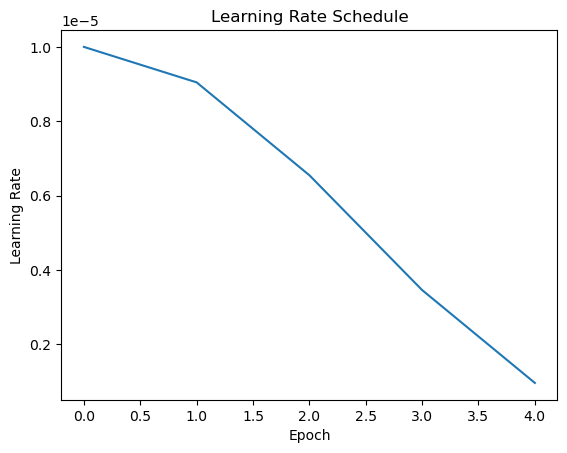

In [55]:
model=get_model()
history=model.fit(train_ds,
                  validation_data=valid_ds,
                  epochs=N_EPOCHS,
                  verbose=VERBOSE,
                  callbacks=[lr_callback,
                             WeightDecayCallback()])
plt.plot(LR_SCHEDULE)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

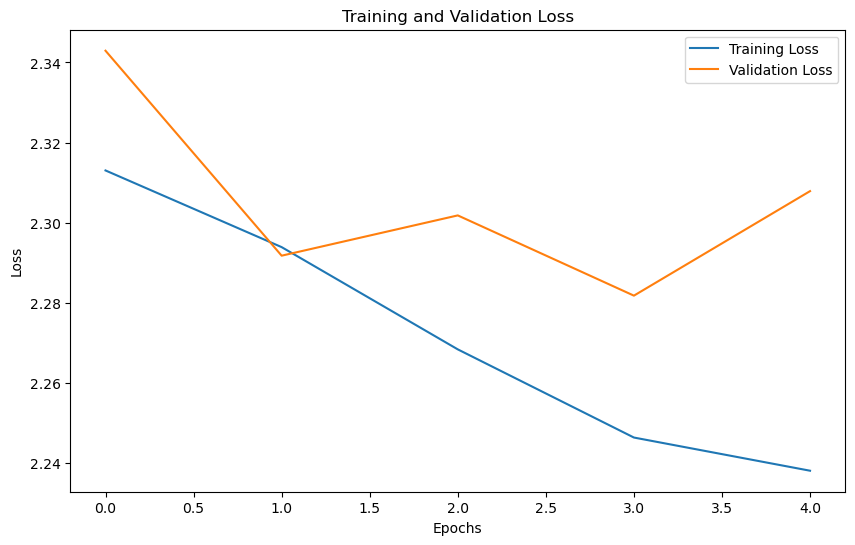

In [56]:
# Get training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 5.7 VGG16

In [96]:
def get_model():
    INPUT_SHAPE = (256, 256, 3)
    
    with STRATEGY.scope():
        # Set seed for deterministic weight initializations
        seed_everything()
        
        # Input, note the names are equal to directory keys in the dataset
        image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.uint8)
        
        # Normalize Input
        image_norm = normalize(image)
        
        # CNN Prediction in range [0, 1]
        x = tf.keras.applications.VGG16(input_shape=[256, 256, 3], weights="imagenet", include_top=False)(image_norm)
        
        # Average Pooling BxhxNxC -> BxC
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        
        # Dropout
        x = tf.keras.layers.Dropout(0.5)(x)
        
        # Output softmax
        
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        
        # We will use Adam optimizer for fast learning with weight decay
        optimizer = tfa.optimizers.AdamW(learning_rate=LR_MAX, weight_decay=LR_MAX * WD_RATIO, epsilon=1e-6)
        
        # Loss
        loss = tf.keras.losses.CategoricalCrossentropy()
        
        # Metrics
        metrics = [
            tfa.metrics.F1Score(num_classes=num_classes),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.BinaryAccuracy()
        ]
        
        model = tf.keras.models.Model(inputs=image, outputs=outputs)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
        return model


In [97]:
model=get_model()

learning rate: 1.00e-05, weight decay: 1.00e-10
Epoch 1/5
75/75 [==============================] - 11s 87ms/step - loss: 2.5091 - f1_score: 0.1386 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - auc_16: 0.5580 - binary_accuracy: 0.8987 - val_loss: 1.9092 - val_f1_score: 0.1939 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_auc_16: 0.7924 - val_binary_accuracy: 0.9000 - lr: 1.0000e-05
learning rate: 9.76e-06, weight decay: 9.76e-11
Epoch 2/5
75/75 [==============================] - 5s 70ms/step - loss: 1.4843 - f1_score: 0.4744 - precision_16: 0.7447 - recall_16: 0.2333 - auc_16: 0.8737 - binary_accuracy: 0.9153 - val_loss: 1.6882 - val_f1_score: 0.4093 - val_precision_16: 0.4250 - val_recall_16: 0.3400 - val_auc_16: 0.8554 - val_binary_accuracy: 0.8880 - lr: 9.7553e-06
learning rate: 9.05e-06, weight decay: 9.05e-11
Epoch 3/5
75/75 [==============================] - 5s 71ms/step - loss: 0.7514 - f1_score: 0.7969 - precision_16: 0.8250 - recall_16: 0.6600 - auc_16

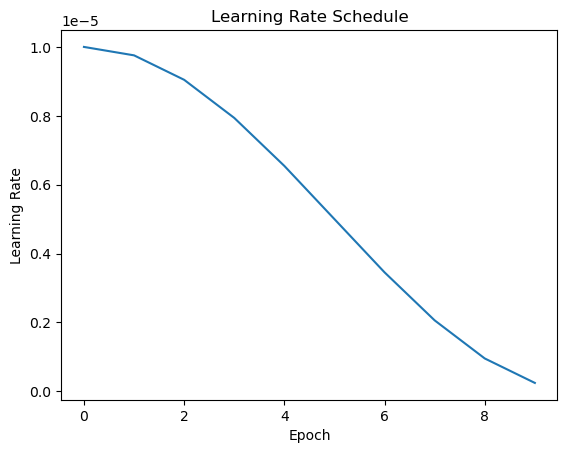

In [98]:
model=get_model()
history=model.fit(train_ds,
                  validation_data=valid_ds,
                  epochs=N_EPOCHS,
                  verbose=VERBOSE,
                  callbacks=[lr_callback,
                             WeightDecayCallback()])
plt.plot(LR_SCHEDULE)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

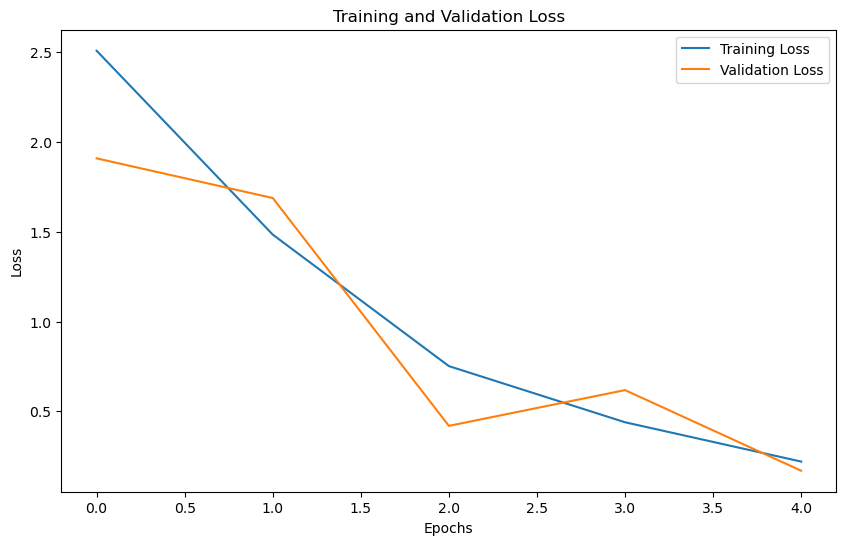

In [99]:
# Get training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 6 Prediction

## 6.1 EfficientNetB5"

In [52]:
y_test = []  # True labels
y_pred = []  # Predicted labels

for image_batch, label_batch in test_ds:
    # Append True Labels
    y_test.append(label_batch)
    
    # Compute Predictions
    preds = model.predict(image_batch)
    
    # Convert Predictions to Label Indices
    predicted_indices = tf.argmax(preds, axis=1)
    
    # Append Predicted Labels
    y_pred.append(predicted_indices)
    
# Convert True and Predicted Labels into Tensors
correct_labels = tf.concat(y_test, axis=0)
predicted_labels = tf.concat(y_pred, axis=0)

# Convert correct_labels to tensor of shape (num_samples,)
correct_labels = tf.argmax(correct_labels, axis=1)

# Convert tensors to numpy arrays
correct_labels_np = correct_labels.numpy()
predicted_labels_np = predicted_labels.numpy()


1/1 [==============================] - 0s 158ms/step


In [38]:
for image_batch, label_batch in test_ds:
    print(image_batch)
    print(label_batch)

tf.Tensor(
[[[[176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]
   ...
   [176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]]

  [[176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]
   ...
   [176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]]

  [[176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]
   ...
   [176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]]

  ...

  [[176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]
   ...
   [176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]]

  [[176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]
   ...
   [176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]]

  [[176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]
   ...
   [176. 114.  74.]
   [176. 114.  74.]
   [176. 114.  74.]]]


 [[[159.   0. 255.]
   [159.   0. 255.]
   [159.   0. 255.]
   ...
   [159.   0. 255.]
   [159.   0. 255.]
   [159.   0. 255.]]

  [[159.   0. 255.]
   [159.   0. 255.]
   [159.   0. 255.]
   ...
   [159.  

## 6.3 EfficientNetB7 (Paper Architecture)

In [63]:
y_pred= []
y_test= []

y_test = []  # True labels
y_pred = []  # Predicted labels

for image_batch, label_batch in test_ds:
    # Append True Labels
    y_test.append(label_batch)
    
    # Compute Predictions
    preds = model.predict(image_batch)
    
    # Convert Predictions to Label Indices
    predicted_indices = tf.argmax(preds, axis=1)
    
    # Append Predicted Labels
    y_pred.append(predicted_indices)
    
# Convert True and Predicted Labels into Tensors
correct_labels = tf.concat(y_test, axis=0)
predicted_labels = tf.concat(y_pred, axis=0)


1/1 [==============================] - 0s 172ms/step


## 6.4 VGG16

In [100]:
y_test = []  # True labels
y_pred = []  # Predicted labels

for image_batch, label_batch in test_ds:
    # Append True Labels
    y_test.append(label_batch)
    
    # Compute Predictions
    preds = model.predict(image_batch)
    
    # Convert Predictions to Label Indices
    predicted_indices = tf.argmax(preds, axis=1)
    
    # Append Predicted Labels
    y_pred.append(predicted_indices)
    
# Convert True and Predicted Labels into Tensors
correct_labels = tf.concat(y_test, axis=0)
predicted_labels = tf.concat(y_pred, axis=0)


1/1 [==============================] - 0s 157ms/step


# 7 Evaluation

## 7.1 EfficientNetB5

In [35]:
model.evaluate(test_ds)

25/25 [==============================] - 1s 45ms/step - loss: 2.3193 - f1_score: 0.0442 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4992 - binary_accuracy: 0.9000


[2.3193423748016357,
 array([0.        , 0.        , 0.        , 0.        , 0.37500003,
        0.        , 0.        , 0.        , 0.06666667, 0.        ],
       dtype=float32),
 0.0,
 0.0,
 0.4991777539253235,
 0.8999999761581421]

In [38]:
model.save_weights('HCC_EfficientB5_60_W.h5')

In [39]:
model.save('DF_EfficientB5_60.h5')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

## 7.2 EfficientNetB7

In [64]:
model.evaluate(test_ds)

25/25 [==============================] - 2s 64ms/step - loss: 13566.4883 - f1_score: 0.0450 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.4664 - binary_accuracy: 0.8920


[13566.48828125,
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.25      , 0.20000002, 0.        ],
       dtype=float32),
 0.0,
 0.0,
 0.46637779474258423,
 0.8920000195503235]

In [ ]:
model.save_weights('DF_EfficientB5_88_W.h5')

In [ ]:
model.save('DF_EfficientB5_88_W.h5')

In [ ]:
model.save('DF_EfficientB5_88.h5')

## 7.3 VGG16

In [103]:
model.evaluate(test_ds)

25/25 [==============================] - 1s 39ms/step - loss: 0.2222 - f1_score: 0.8984 - precision_16: 0.9184 - recall_16: 0.9000 - auc_16: 0.9978 - binary_accuracy: 0.9820


[0.22220851480960846,
 array([0.90909094, 1.        , 0.75      , 1.        , 0.88888896,
        0.72727275, 0.90909094, 1.        , 1.        , 0.8000001 ],
       dtype=float32),
 0.918367326259613,
 0.8999999761581421,
 0.997844398021698,
 0.9819999933242798]

In [104]:
from sklearn.metrics import classification_report
classification_report(correct_labels.numpy(), predicted_labels.numpy())

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [105]:
model.save_weights('VGG16_98.5_W.h5')

In [106]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [108]:
# Save the TFLite model to a file
with tf.io.gfile.GFile('VGG16_98.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
model.save('VGG16_92.5')

## 8 New Information 

### 8.1 Weight Decay



Weight decay is a regularization technique commonly used during model training to prevent overfitting. It is also known as L2 regularization or Ridge regularization. The purpose of weight decay is to add a penalty term to the loss function that discourages the model from assigning excessively large weights to the parameters.

The main motivation behind weight decay is to encourage the model to learn simpler and more generalizable patterns from the data. When training a neural network, the model has a tendency to assign high weights to certain parameters, which can result in overfitting. Overfitting occurs when the model becomes too specialized to the training data and performs poorly on unseen or test data.

Weight decay helps alleviate overfitting by adding a regularization term to the loss function that penalizes large weights. The regularization term is proportional to the square of the weights, encouraging the model to find a balance between fitting the training data and avoiding large weights. This encourages the model to generalize better to unseen data.

The weight decay term is controlled by a hyperparameter called the weight decay coefficient or decay rate. This coefficient determines the strength of the weight decay regularization. By tuning the weight decay coefficient, you can control the trade-off between fitting the training data and preventing overfitting.

### 8.2  TFLite model
 TFLite model (optional): Quantization is a technique to reduce the size of the model further and improve its performance on resource-constrained devices. TensorFlow Lite supports several quantization methods. If you wish to quantize your TFLite model, you can apply quantization-aware training during the training phase or perform post-training quantization during the conversion smtep. Refer to the TensorFlow Lite documentation for more information on model quantization techniques.